# Cross-correlation Sampler

Sampler for cross-coupling systematics (only) in a cross-correlation visibility. Reflections are modelled in the autocorrelations (Reflection_Sampler.ipynb). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import arviz as az

import pymc3 as pm

import theano.tensor as T

from scipy.signal import windows
from numpy.fft import fft, fftshift, ifftshift
from astropy import units

from Delay_Transform import gen_window
from Delay_Transform import fourier_freqs
from Delay_Transform import FFT

from Systematics_Functions import Auto_Systematics, Auto_Systematics_No_T, Auto_Subtract, Cross_Systematics, Cross_Systematics_No_T

In [2]:
def Fourier_Transform(freqs,data,freq_taper):

    plot_units = {
        "lst": "hour",
        "time": "day",
        "freq": "MHz",
        "fringe-rate": "mHz",
        "delay": "ns"
    }
    

    scale_factor = 1 # Get FFT data units right.
    
    scale_factor *= np.mean(np.diff(freqs)) # Hz
    delays = fourier_freqs(freqs) * units.s.to(plot_units["delay"])
    data = np.atleast_2d(data)
    data = FFT(data, axis=1, taper=freq_taper)

    
    #Delay Space
    data *= scale_factor
    
    return([delays,data])

In [3]:
'''Power spectrum plotter'''

def Delay_Plot(FT_Data, label, color, linestyle):
    plt.plot(FT_Data[0], np.abs(FT_Data[1][0]*np.conj(FT_Data[1][0])),
             linewidth=1.25, label=label, color=color, linestyle=linestyle)

    plt.legend(frameon=False)
    plt.yscale('log')
    plt.xlim(-500,2000)
    #plt.ylim(1e1,5e17)
    plt.xlabel('$\\tau$ [ns]',fontsize=12)
    plt.ylabel('|$\\rm{V}_{\\rm{ab}}$|$^2$($\\nu$) [Jy Hz]$^2$',fontsize=12)
    plt.tight_layout()

In [4]:
#Data to be modelled - subselect the middle 512 frequency channels (no noise inserted yet)

Data = np.load('example_data/coupling_sampling/zen.2458098.26719.sum.corrupt.1.2.COUPLING.npy')[0][75:587]
freqs = np.load("example_data/freqs.npy", allow_pickle=True)[0][75:587]

Data_FT = Fourier_Transform(freqs,Data,'blackman-harris')

## Bayesian Model

In [5]:
'''Use the autocorrelations corresponding to the baseline to form the noise estimate
    Also increase the time integration by a factor of 100, otherwise the noise is as 
    strong as the strongest coupling peaks.'''

#Vectorise the autos to keep with the convention for pymc3, even though it should be fully real
Auto_1 = np.load('example_data/coupling_sampling/zen.2458098.26719.sum.corrupt.1.1.COUPLING.npy')[0][75:587]
Auto_1=[Auto_1.real,Auto_1.imag]
Auto_2 = np.load('example_data/coupling_sampling/zen.2458098.26719.sum.corrupt.2.2.COUPLING.npy')[0][75:587]
Auto_2=[Auto_2.real,Auto_2.imag]

dt = 10.73 * 100 #Integration time in seconds
freq_width = freqs[1] - freqs[0] #Frequency channel width in Hz

sigma = np.sqrt(np.abs((Auto_1[0])*(Auto_2[0]))/(dt*freq_width))

#Form the complex noise visibility
sigma_comp = sigma*np.random.normal(loc=0.0, scale=1, size=512)/np.sqrt(2) + 1j*sigma*np.random.normal(loc=0.0, scale=1, size=512)/np.sqrt(2)
sigma_comp_FT = Fourier_Transform(freqs,sigma_comp,'blackman-harris')

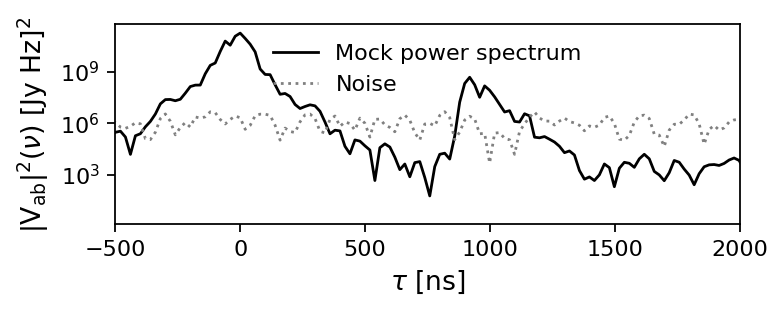

In [6]:
'''Compare the noise to the mock power spectrum'''

fig, axes = plt.subplots(figsize=(5,2),dpi=160)

Delay_Plot(Data_FT, 'Mock power spectrum', 'k', '-')
Delay_Plot(sigma_comp_FT, 'Noise', 'grey', ':')
plt.legend(frameon=False, loc='upper center')

In [7]:
'''Model Components'''

#Form the noisy mock data for the likelihood
Y = np.column_stack([Data.real + sigma_comp.real, Data.imag + sigma_comp.imag])
#Y = np.column_stack([Data.real, Data.imag])

FG_Evecs = np.load('components/FG_evecs_cross.npy') #Foreground eigenvectors

EoR_FModes = np.load('components/EoR_fModes_cross.npy') #Signal Fourier modes

#Vectorise for the sampler
FG_Evecs_Split = [FG_Evecs.real, FG_Evecs.imag]
EoR_FModes_Split = [EoR_FModes.real, EoR_FModes.imag]

#Noise estimate for the sampler
sig_T = np.column_stack([np.sqrt(np.abs((Auto_1[0])*(Auto_2[0]))/(dt*freq_width)),
                         np.sqrt(np.abs((Auto_1[0])*(Auto_2[0]))/(dt*freq_width))])

In [8]:
'''Parameter estimates

Define the best estimates for the parameters present in the model. 
These become the prior means.'''

#Cross-coupling (Number of peaks, delays, amplitudes, delays)
    #Amplitudes estimated by assuming regular decrease in power in log-space 
cc_amps_est = np.array([9.95252584e-05, 5.98697620e-05, 3.64097689e-05, 2.14640015e-05,
       1.28986771e-05, 7.82976785e-06, 4.67862127e-06, 2.78681450e-06,
       1.65876101e-06, 9.87467491e-07])

    #Delays esimated by assuming even spacing across 900-1300 ns
cc_dlys_est = np.array([9.16209506e-07, 9.69258527e-07, 1.02690720e-06, 1.01504102e-06,
       1.06904124e-06, 1.14706198e-06, 1.16638231e-06, 1.19135034e-06,
       1.23001230e-06, 1.24947163e-06])

#---------------------------------

#Foreground amplitudes (these amplitudes found with a vector projection)
Projected = np.array([0.3066023634826655-0.3267945981959901j,
 0.46218542878084135+0.40575111712840606j,
 0.370448656736457+0.11874211544684493j,
 0.06723510829023142+0.05500769921616373j,
 -0.10094504204742737+0.020635834419853647j,
 0.04606670476730481+0.058850284531743964j,
 -0.01741316633376589+0.000585145195337318j,
 0.0012826753117864478+0.009049715924997509j])

FGAmps_est_real = Projected.real
FGAmps_est_imag = Projected.imag

#---------------------------------

#EoR amplitudes, found by a Fourier decomposition of an auto model signal - decrease amps for the crosses
EORAmps_est = np.ones(199)*0.25

cc_Ncopies = len(cc_dlys_est)

N_EoR_Modes = 199
N_FG_Evecs = 8

In [9]:
'''Make a plot of the estimates as a quick check'''

Estimate_Plot = Cross_Systematics_No_T(refl_amp=0,refl_dly=0,refl_phs=0,
                cc_amps=cc_amps_est, cc_dlys_pos=cc_dlys_est, cc_dlys_neg=0, cc_phs=np.zeros(cc_Ncopies),
                subreflAmps=0, subreflDlys=0, subreflPhses=0,
                FGAmps_real=FGAmps_est_real,FGAmps_imag=FGAmps_est_imag,FG_Evecs=FG_Evecs_Split,EORFAmps=[0],
                                  EOR_FModes=EoR_FModes_Split, freqs=freqs, cc_Ncopies=cc_Ncopies, NSubrefls=0,
                                  N_FAmps=N_EoR_Modes,N_FGAmps=N_FG_Evecs,autovis=Auto_1)

Estimate_Plot_FT = Fourier_Transform(freqs, Estimate_Plot[:,0] + Estimate_Plot[:,1]*1j,'blackman-harris')

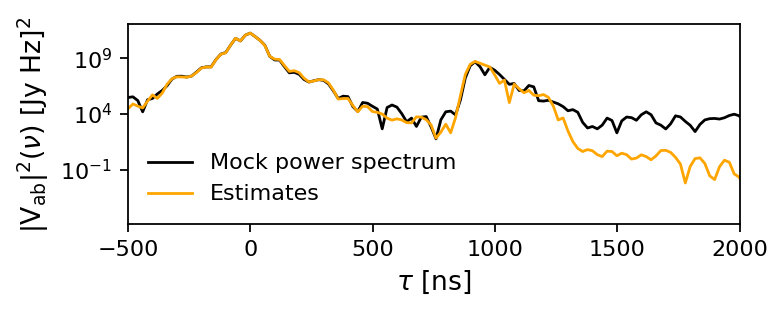

In [10]:
fig, axes = plt.subplots(figsize=(5,2),dpi=160)

Delay_Plot(Data_FT, 'Mock power spectrum', 'k', '-')
Delay_Plot(Estimate_Plot_FT, 'Estimates', 'orange', '-')

In [11]:
with pm.Model() as model_cross:
    
    '''Foreground Eigenvector Amplitudes'''
    
    FR = pm.Normal('FR', mu=0,sigma=1,shape=N_FG_Evecs)
    FI = pm.Normal('FI', mu=0,sigma=1,shape=N_FG_Evecs)
    
    FGAmps_real = pm.Deterministic('FGAmps_real', FGAmps_est_real+0.05*FGAmps_est_real*FR)
    FGAmps_imag = pm.Deterministic('FGAmps_imag', FGAmps_est_imag+0.05*FGAmps_est_imag*FI)
    
    '''EOR Fourier Mode Amps'''
    '''EORFAmps = pm.Normal('EORFAmps',mu=EORAmps_Guess,sigma=1e-5,shape=N_FAmps)'''
    EORFAmps = pm.Normal('EORFAmps',mu=EORAmps_est,sigma=EORAmps_est*5,shape=N_EoR_Modes)
    
    cc_dlys_pos = pm.Normal("cc_dlys_pos", mu=0, sigma=1, shape=cc_Ncopies)
    cc_dlys_pos_scaled = pm.Deterministic("cc_dlys_pos_scaled", cc_dlys_est + cc_dlys_pos*10e-9)
    
    cc_amps = pm.Normal("cc_amps", mu=0, sigma=1, shape=cc_Ncopies)
    cc_amps_scaled = pm.Deterministic("cc_amps_scaled", cc_amps_est + cc_amps*cc_amps_est*0.05)

    cc_phs = pm.Normal("cc_phs", mu=0, sigma=1, shape=cc_Ncopies)
    
   
    Y_Obs = pm.Normal("obs", mu=Cross_Systematics(refl_amp=0,refl_dly=0,refl_phs=0,
                                            cc_amps=cc_amps_scaled, cc_dlys_pos=cc_dlys_pos_scaled, cc_dlys_neg=0, cc_phs=cc_phs,
                                            subreflAmps=0, subreflDlys=0, subreflPhses=0,
                                            FGAmps_real=FGAmps_real,FGAmps_imag=FGAmps_imag,FG_Evecs=FG_Evecs_Split,
                                                  EORFAmps=[0], EOR_FModes=EoR_FModes_Split, freqs=freqs, cc_Ncopies=cc_Ncopies, 
                                                  NSubrefls=0, N_FAmps=N_EoR_Modes,N_FGAmps=N_FG_Evecs,autovis=Auto_1), 
                      observed=Y,sigma=sig_T)
    

In [12]:
'''Sampler setup and run

    - >1 chain for diagnostics purposes
    - jitter+adapt_diag seems to be better for this case
    - arbitrarily large number of initialisation steps to ensure convergence
    - use more tuning steps for lower noise cases (to help prevent divergences in the sampling), or
        for better results overall - more tuning generally results in better model estimates. Can also 
        help with convergence issues
    - increase number of draws for better stats
    - increase target accept above 0.8 (default) if there are divergences (but slows the sampler)'''

with model_cross:
    trace = pm.sample(
        chains=2,
        cores=2,
        init='jitter+adapt_diag',
        n_init=1000000,
        draws=5000,
        tune=4000,
        target_accept=0.9,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cc_phs, cc_amps, cc_dlys_pos, EORFAmps, FI, FR]


Sampling 2 chains for 4_000 tune and 5_000 draw iterations (8_000 + 10_000 draws total) took 794 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
'''Save the trace'''
#trace.to_netcdf("traces/1_2_trace_100_integrations_update.nc")
#np.save("traces/1_2_trace_100_integrations_update.npy", dict(trace.posterior))

'traces/1_2_trace_100_integrations_update.nc'

## Comparison and Recovery

### Autocorrelation Recovery

In [17]:
'''Load a trace'''
#trace = az.from_netcdf("traces/1_2_trace_100_integrations_update.nc")
trace = np.load('traces/1_2_trace_100_integrations_update.npy',allow_pickle=True).item()

In [18]:
'''Combine however many chains have been used in sampling'''

#This for .nc traces
'''N_chains = np.shape(trace.posterior['cc_amps_scaled'])[0]
N_samples = np.shape(trace.posterior['cc_amps_scaled'])[1]

cc_amps_result = np.array(trace.posterior['cc_amps_scaled']).reshape(N_chains*N_samples, cc_Ncopies)

cc_dlys_pos_result = np.array(trace.posterior['cc_dlys_pos_scaled']).reshape(N_chains*N_samples, cc_Ncopies)

cc_phs_result = np.array(trace.posterior['cc_phs']).reshape(N_chains*N_samples, cc_Ncopies)


FGAmps_real_result = np.array(trace.posterior['FGAmps_real']).reshape(N_chains*N_samples, N_FG_Evecs)

FGAmps_imag_result = np.array(trace.posterior['FGAmps_imag']).reshape(N_chains*N_samples, N_FG_Evecs)

EORFAmps_result = np.array(trace.posterior['EORFAmps']).reshape(N_chains*N_samples, N_EoR_Modes)'''

#This for traces converted to dicts/.npy files
N_chains = np.shape(trace['cc_amps_scaled'])[0]
N_samples = np.shape(trace['cc_amps_scaled'])[1]

cc_amps_result = np.array(trace['cc_amps_scaled']).reshape(N_chains*N_samples, cc_Ncopies)

cc_dlys_pos_result = np.array(trace['cc_dlys_pos_scaled']).reshape(N_chains*N_samples, cc_Ncopies)

cc_phs_result = np.array(trace['cc_phs']).reshape(N_chains*N_samples, cc_Ncopies)


FGAmps_real_result = np.array(trace['FGAmps_real']).reshape(N_chains*N_samples, N_FG_Evecs)

FGAmps_imag_result = np.array(trace['FGAmps_imag']).reshape(N_chains*N_samples, N_FG_Evecs)

#EORFAmps_result = np.array(trace['EORFAmps']).reshape(N_chains*N_samples, N_EoR_Modes)

In [19]:
'''Form an array containing visibilities corresponding to all samples, i.e. one step
    in the chain becomes one visibility'''

Model_Results_All = []

for qq in range(0,N_chains*N_samples):
    
    #Print some sort of progress
    if qq % 1000 == 0:
            print(str(qq) + '/' + str(N_chains*N_samples),end=' ')
    
    Model_Results = Cross_Systematics_No_T(refl_amp=0,refl_dly=0,refl_phs=0,
                cc_amps=cc_amps_result[qq], cc_dlys_pos=cc_dlys_pos_result[qq], cc_dlys_neg=0, cc_phs=cc_phs_result[qq],
                subreflAmps=0, subreflDlys=0, subreflPhses=0,
                FGAmps_real=FGAmps_real_result[qq],FGAmps_imag=FGAmps_imag_result[qq],FG_Evecs=FG_Evecs_Split,EORFAmps=[0],
                                  EOR_FModes=EoR_FModes_Split, freqs=freqs, cc_Ncopies=cc_Ncopies, NSubrefls=0,
                                  N_FAmps=N_EoR_Modes,N_FGAmps=N_FG_Evecs,autovis=Auto_1)

    
    Model_Results_complex = Model_Results[:,0] + Model_Results[:,1]*1j
    
    Model_Results_FT = Fourier_Transform(freqs,Model_Results_complex,'blackman-harris')

    
    Model_Results_All.append(Model_Results_FT[1][0])
    
Model_Results_All = np.array(Model_Results_All)

0/10000 1000/10000 2000/10000 3000/10000 4000/10000 5000/10000 6000/10000 7000/10000 8000/10000 9000/10000 

In [20]:
'''Find the 95th percentile of the model visibilities'''

mean = []
perc_95 = []
perc_5 = []

for vv in range(0,512):
    mean.append(np.mean(np.abs(Model_Results_All.T[vv])))
    perc_95.append(np.percentile(np.abs(Model_Results_All.T[vv]), 95, axis=0))
    perc_5.append(np.percentile(np.abs(Model_Results_All.T[vv]), 5, axis=0))

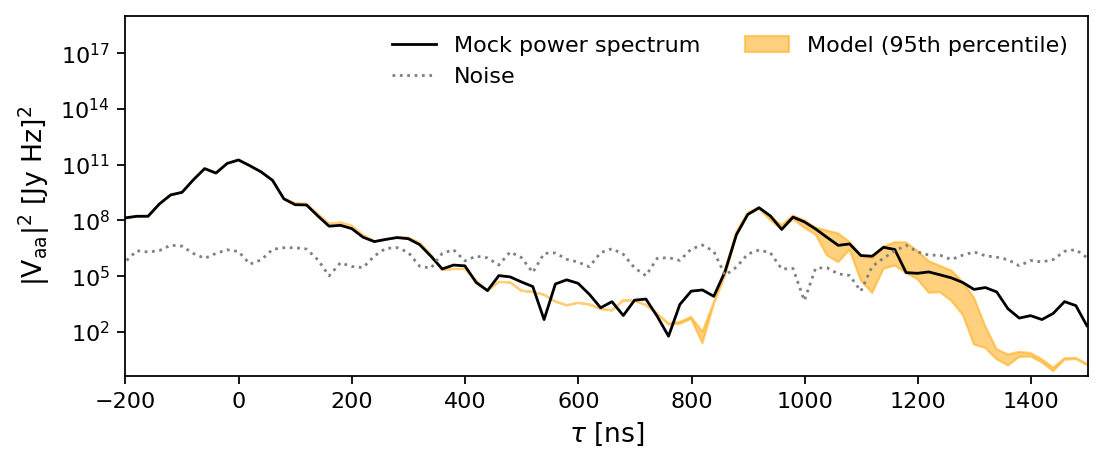

In [21]:
fig, axs = plt.subplots(figsize=(7,3),dpi=160)

Delay_Plot(Data_FT, 'Mock power spectrum', 'k', '-')
Delay_Plot(sigma_comp_FT, 'Noise', 'grey', ':')
#Delay_Plot(Data_Gains_FT, 'True power spectrum', 'green', '--')

plt.fill_between(Data_FT[0],np.abs(perc_5*np.conj(perc_5)),np.abs(
    perc_95*np.conj(perc_95)),
                    color='orange',linewidth=1,alpha=0.5,label='Model (95th percentile)')

plt.yscale('log')
plt.xlim(-200,1500)
plt.ylim(4e-1,1e19)
#plt.axvline(940)
plt.legend(frameon=False,ncol=2)

plt.ylabel('|V$_{\\rm{aa}}$|$^2$ [Jy Hz]$^2$',fontsize=12)

plt.xlabel('$\\tau$ [ns]',fontsize=12)
fig.tight_layout()


In [22]:
Chain_Results_FT_All = []

for qq in range(0,10000):
    
    if qq % 1000 == 0:
        print(str(qq) + '/' + str(N_chains*N_samples),end=' ')
        
    #Form the model power spectra
    Model_Results = Cross_Systematics_No_T(refl_amp=0,refl_dly=0,refl_phs=0,
                cc_amps=cc_amps_result[qq], cc_dlys_pos=cc_dlys_pos_result[qq], cc_dlys_neg=0, cc_phs=cc_phs_result[qq],
                subreflAmps=0, subreflDlys=0, subreflPhses=0,
                FGAmps_real=FGAmps_real_result[qq],FGAmps_imag=FGAmps_imag_result[qq],FG_Evecs=FG_Evecs_Split,EORFAmps=[0],
                                  EOR_FModes=EoR_FModes_Split, freqs=freqs, cc_Ncopies=cc_Ncopies, NSubrefls=0,
                                  N_FAmps=N_EoR_Modes,N_FGAmps=N_FG_Evecs,autovis=Auto_1)
    
    
    #Form foreground+EoR models only (leave out CC)
    Model_Results_FG_EOR = Cross_Systematics_No_T(refl_amp=0,refl_dly=0,refl_phs=0,
                cc_amps=cc_amps_result[qq]*0, cc_dlys_pos=cc_dlys_pos_result[qq], cc_dlys_neg=0, cc_phs=cc_phs_result[qq],
                subreflAmps=0, subreflDlys=0, subreflPhses=0,
                FGAmps_real=FGAmps_real_result[qq],FGAmps_imag=FGAmps_imag_result[qq],FG_Evecs=FG_Evecs_Split,EORFAmps=[0],
                                  EOR_FModes=EoR_FModes_Split, freqs=freqs, cc_Ncopies=cc_Ncopies, NSubrefls=0,
                                  N_FAmps=N_EoR_Modes,N_FGAmps=N_FG_Evecs,autovis=Auto_1)
    
    
    #Form the cross-coupling-only visibilities, then subtract this from the mock data
    CC_complex = Model_Results[:,0] + Model_Results[:,1]*1j - Model_Results_FG_EOR[:,0] - Model_Results_FG_EOR[:,1]*1j
    SysCheck_complex = (Data + sigma_comp) - CC_complex


    #FT the recovered visibilities
    Chain_Results_FT = Fourier_Transform(freqs,SysCheck_complex,'blackman-harris')
    Chain_Results_FT_All.append(Chain_Results_FT[1][0])

Chain_Results_FT_All = np.array(Chain_Results_FT_All)

0/10000 1000/10000 2000/10000 3000/10000 4000/10000 5000/10000 6000/10000 7000/10000 8000/10000 9000/10000 

In [23]:
'''Find the 95th percentile of the recovered visibilities'''

mean = []
perc_95 = []
perc_5 = []

for vv in range(0,512):
    mean.append(np.mean(np.abs(Chain_Results_FT_All.T[vv])))
    perc_95.append(np.percentile(np.abs(Chain_Results_FT_All.T[vv]), 95, axis=0))
    perc_5.append(np.percentile(np.abs(Chain_Results_FT_All.T[vv]), 5, axis=0))

In [24]:
Data_True = np.load('example_data/reflection_sampling/zen.2458098.26719.sum.corrupt.1.2.GAINS.npy')[0][75:587]
Data_True_FT = Fourier_Transform(freqs,Data_True,'blackman-harris')

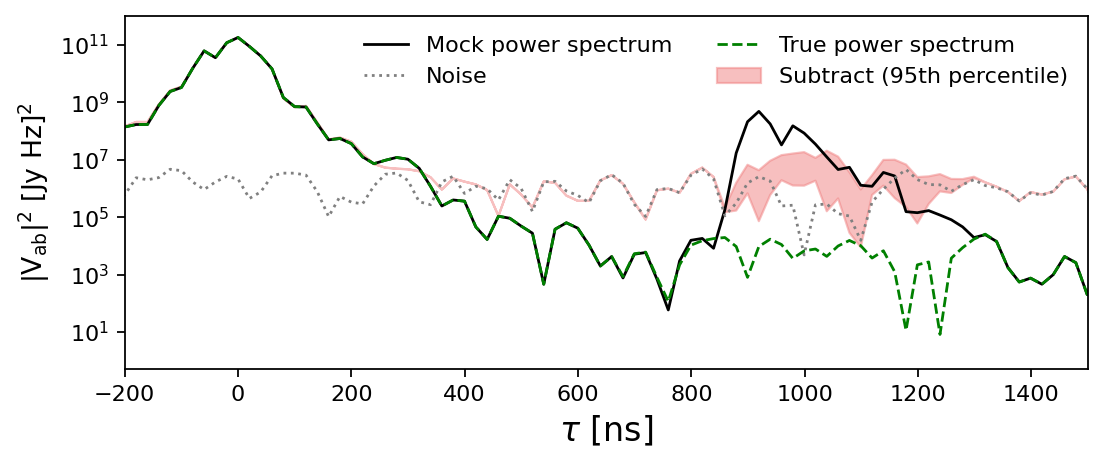

In [25]:
fig, axs = plt.subplots(figsize=(7,3),dpi=160)
Delay_Plot(Data_FT, 'Mock power spectrum', 'k', '-')
Delay_Plot(sigma_comp_FT, 'Noise', 'grey', ':')

plt.fill_between(Data_FT[0],np.abs(perc_5*np.conj(perc_5)),np.abs(perc_95*np.conj(perc_95)),color='lightcoral',linewidth=1,
                 alpha=0.5,label='Subtract (95th percentile)')

Delay_Plot(Data_True_FT, 'True power spectrum', 'green', '--')

plt.yscale('log')
plt.xlim(-200,1500)
plt.ylim(0.5e0,1e12)
#plt.axvline(940)
plt.legend(frameon=False,loc='upper right',ncol=2)

plt.ylabel('|V$_{\\rm{ab}}$|$^2$ [Jy Hz]$^2$',fontsize=12)


plt.xlabel('$\\tau$ [ns]',fontsize=15)

fig.tight_layout()
